In [19]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

import os
import numpy as np
import pandas as pd

# Preprocessing CA housing data 

In [3]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

sorting file paths for each of train, valid, and test set with target values

In [7]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [8]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + housing.target_names
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [9]:
pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


generating dataset from CSV file paths. Also output dataset will be normalized and one prefetch

In [16]:
n_inputs = X_train_full.shape[-1]

def preprocess(line):
    defaluts = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defaluts)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                      n_read_threads=None, shuffle_buffer_size=10000,
                      n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths) 
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(repeat)
    return dataset.batch(batch_size).prefetch(1)

In [17]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

Ready to create and train the model 

In [43]:
model = Sequential()

model.add(Dense(30, activation='relu', input_shape=[8,]))
model.add(Dropout(0.4))

model.add(Dense(15, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(6, activation='relu'))

model.add(Dense(1))

model.compile(loss='mse', optimizer=SGD(learning_rate=0.0005, momentum=0.9))

In [44]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [45]:
history = model.fit(train_set, epochs=50, validation_data=valid_set)

Epoch 1/50
363/363 [==============================] - 1s 3ms/step - loss: 1.3895 - val_loss: 1.3737
Epoch 2/50
363/363 [==============================] - 1s 3ms/step - loss: 0.9013 - val_loss: 0.6338
Epoch 3/50
363/363 [==============================] - 1s 2ms/step - loss: 0.7695 - val_loss: 0.5527
Epoch 4/50
363/363 [==============================] - 1s 2ms/step - loss: 0.7340 - val_loss: 0.5519
Epoch 5/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6882 - val_loss: 0.5124
Epoch 6/50
363/363 [==============================] - 1s 3ms/step - loss: 0.6483 - val_loss: 0.4668
Epoch 7/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6477 - val_loss: 0.4815
Epoch 8/50
363/363 [==============================] - 1s 2ms/step - loss: 0.6114 - val_loss: 0.4591
Epoch 9/50
363/363 [==============================] - 1s 2ms/step - loss: 0.5985 - val_loss: 0.4685
Epoch 10/50
363/363 [==============================] - 1s 2ms/step - loss: 0.5927 - val_loss: 0.4692

In [108]:
losses = pd.DataFrame(history.history)
losses[-10:]

,loss,val_loss
40,0.451337,0.427489
41,0.457191,0.461329
42,0.452784,0.436656
43,0.449019,0.449051
44,0.457941,0.439767
45,0.457585,0.472966
46,0.442707,0.442014
47,0.440497,0.422200
48,0.446081,0.440280
49,0.452216,0.462599


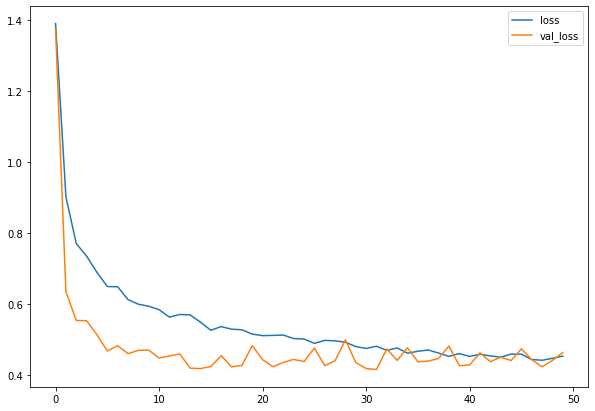

In [113]:
losses.plot(figsize=(10, 7));

In [47]:
model.evaluate(test_set, verbose=0)

0.4791138768196106

In [48]:
new_set = test_set.take(1).map(lambda X, y: X)

In [49]:
model.predict(new_set)[:5]

array([[1.2668271 ],
       [2.1194782 ],
       [1.4884531 ],
       [0.98702466],
       [1.2883203 ]], dtype=float32)

In [106]:
for X, y in test_set.take(1):
    print(y[0])

tf.Tensor([2.134], shape=(1,), dtype=float32)


In [103]:
new_X = tf.constant([0.03244239,  1.216324,   -0.40295774, -0.16929784, -0.11798318,  0.01643894,
 -0.75726473,  0.60190356])

In [105]:
model.predict([new_X])

array([[2.1423006]], dtype=float32)